# Single countries

Single countries data.

> Max Pierini

Twenty countries with more cases.

In [1]:
import datetime as dt

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date

from IPython.display import Markdown, display, Math
import pandas as pd

import arviz as az
import pyjags

In [2]:
T = pd.read_csv(
    "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/csv/COVID-Confirmed.csv",
    index_col=["Country/Region"]
).sort_index()
R = pd.read_csv(
    "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/csv/COVID-Recovered.csv",
    index_col=["Country/Region"]
).sort_index()
D = pd.read_csv(
    "https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/csv/COVID-Deaths.csv",
    index_col=["Country/Region"]
).sort_index()

In [3]:
T.drop(['Province/State', "Lat", 'Long'], 1, inplace=True)
R.drop(['Province/State', "Lat", 'Long'], 1, inplace=True)
D.drop(['Province/State', "Lat", 'Long'], 1, inplace=True)

In [4]:
days = pd.to_datetime(T.columns.values, infer_datetime_format=True)
countries = T.index.get_level_values('Country/Region').unique().sort_values()

In [5]:
_ = """print(f"FIRST ENTRY DATE: {days[0]}")

print(f"LAST  ENTRY DATE: {days[-1]}")

period = (days[-1] - days[0]).days

print("COVERAGE: {} days".format(period))
print("CURRENT DATE IS: {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))"""

In [6]:
SI_mu = 7.5
SI_sd = 3.4

modelString = f"""
model {{
    ###################################
    # Rt estimation
    ###################################
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 0.001 , 0.001 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {{
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }}
}}
"""

In [7]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

def hampel_filter_dataframe(dataframe, window, sigmas):
    framedict = {'data': dataframe.index}
    for col in dataframe.columns:
        filtered, _ = hampel_filter_pandas(dataframe[col], window, sigmas)
        framedict.update({col: filtered})
    newframe = pd.DataFrame(framedict)
    newframe.set_index('data', inplace=True)
    return newframe

In [8]:
sortedT = T.sort_values(by=T.columns[-1], axis=0, ascending=False)
best_countries = sortedT.index[0:20].sort_values().values
print("COUNTRIES: {}".format(best_countries))

COUNTRIES: ['Argentina' 'Bangladesh' 'Brazil' 'Chile' 'Colombia' 'France' 'Germany'
 'India' 'Iran' 'Italy' 'Mexico' 'Pakistan' 'Peru' 'Russia' 'Saudi Arabia'
 'South Africa' 'Spain' 'Turkey' 'US' 'United Kingdom']


In [9]:
#google = pd.read_csv(
#    "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv",
#    parse_dates=['date'], dtype={"sub_region_1": str, "sub_region_2": str},
#    index_col=["date"]
#)
google = pd.read_pickle("../Italia/google-mobility.pkl")

In [10]:
adapt = 100
warmup = 500
sample = 500

# Argentina

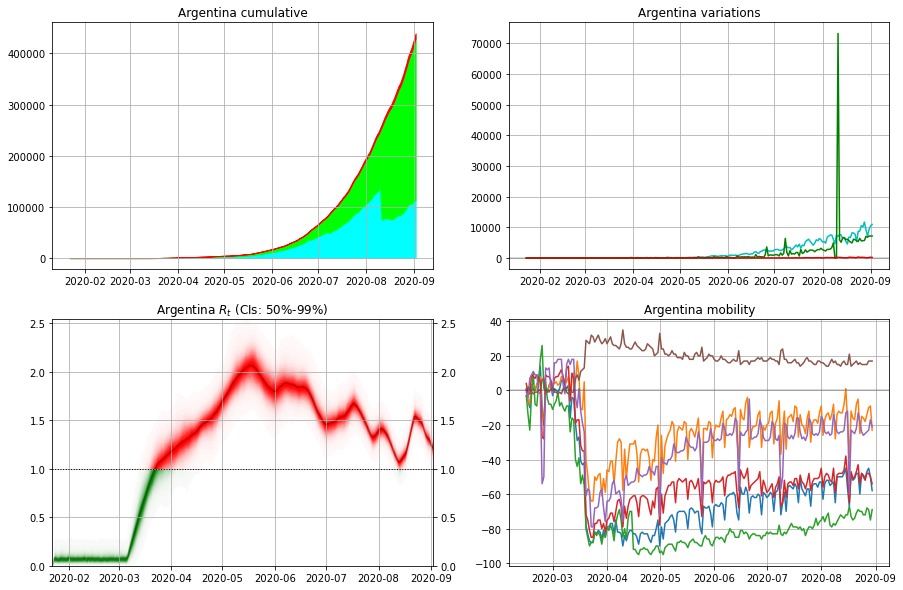

# Bangladesh

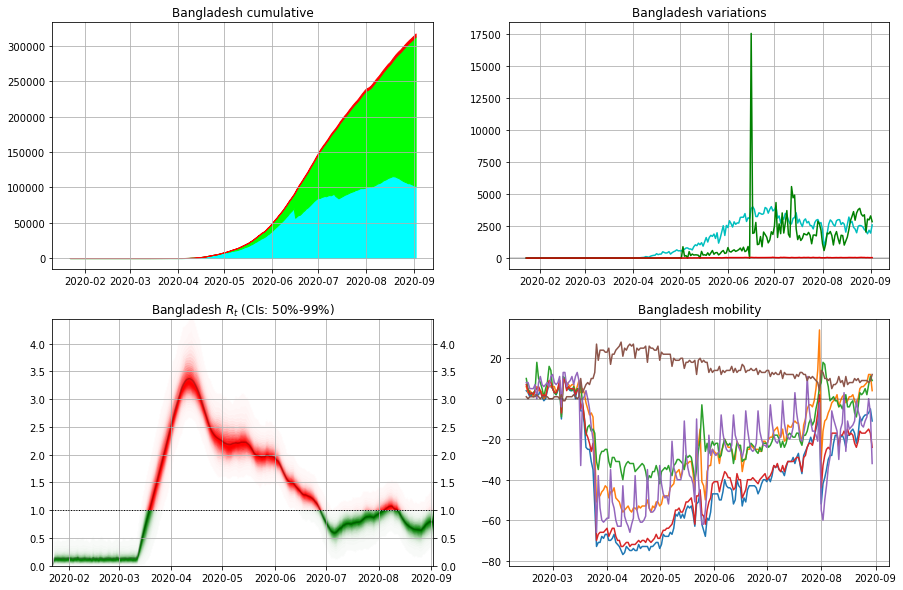

# Brazil

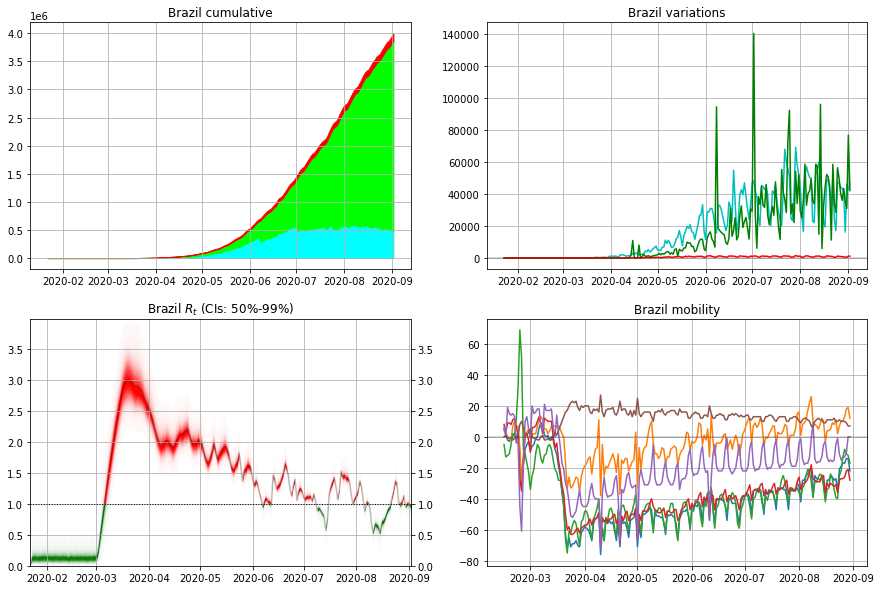

# Chile

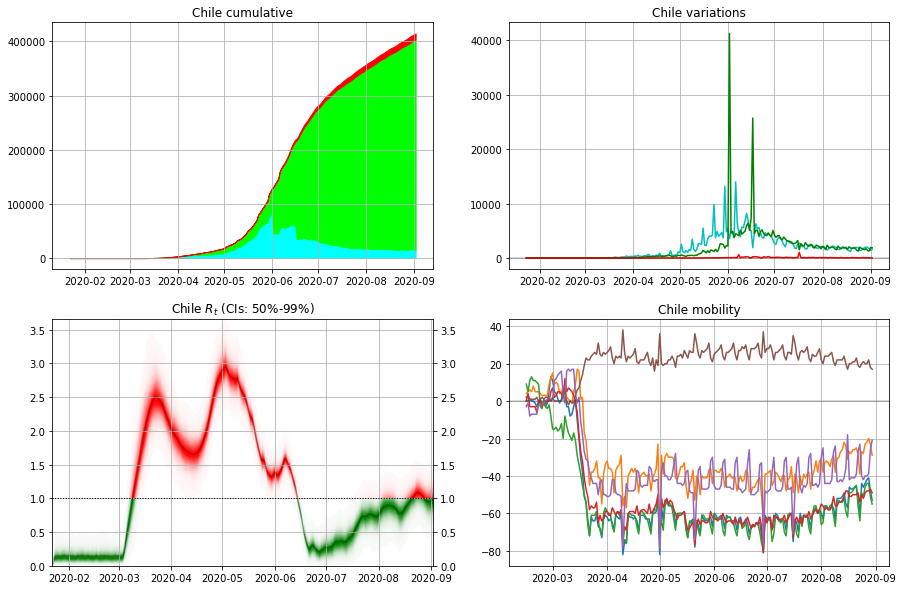

# Colombia

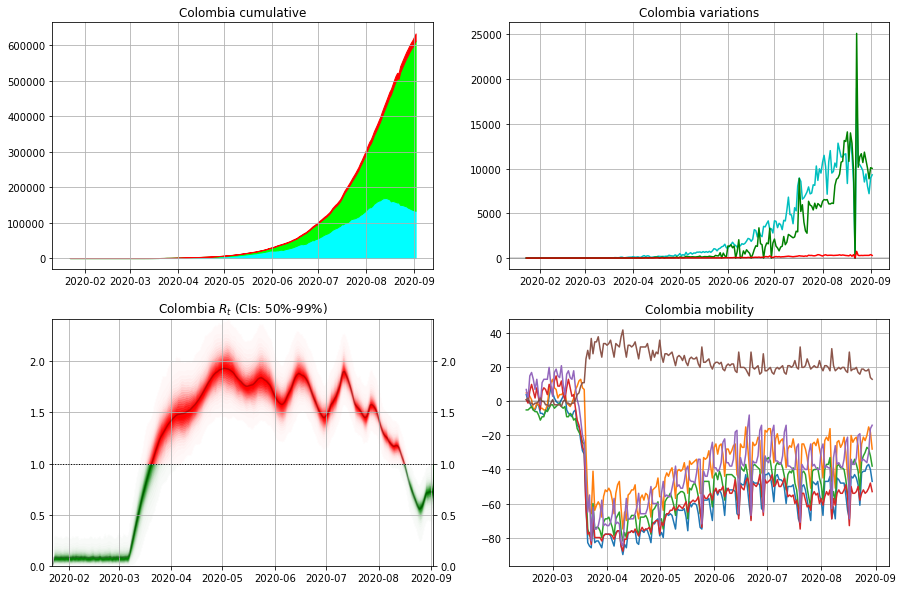

# France

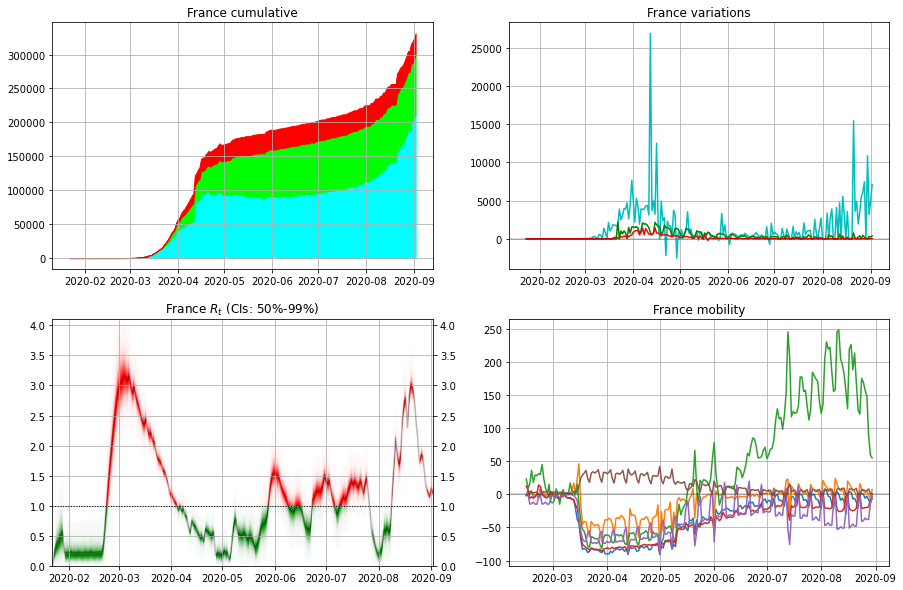

# Germany

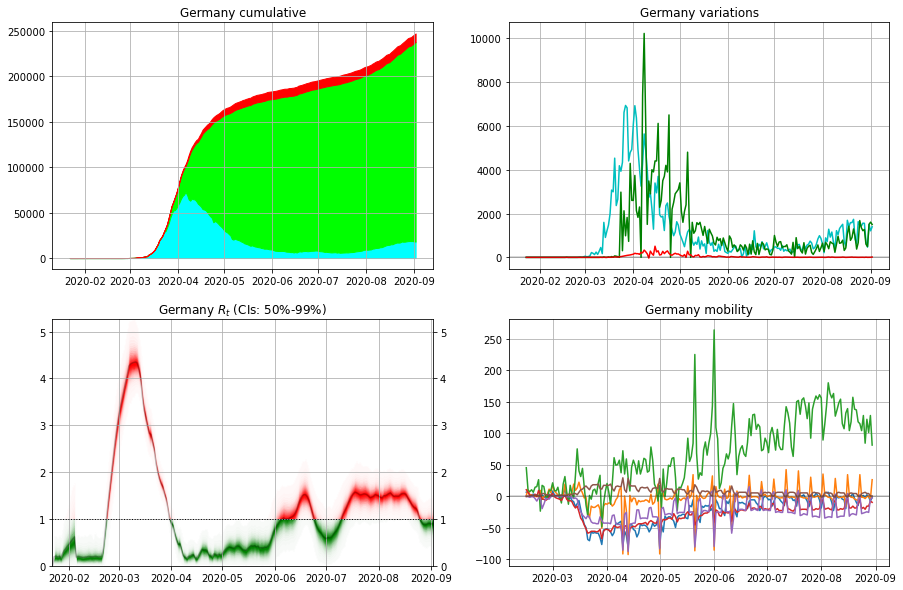

# India

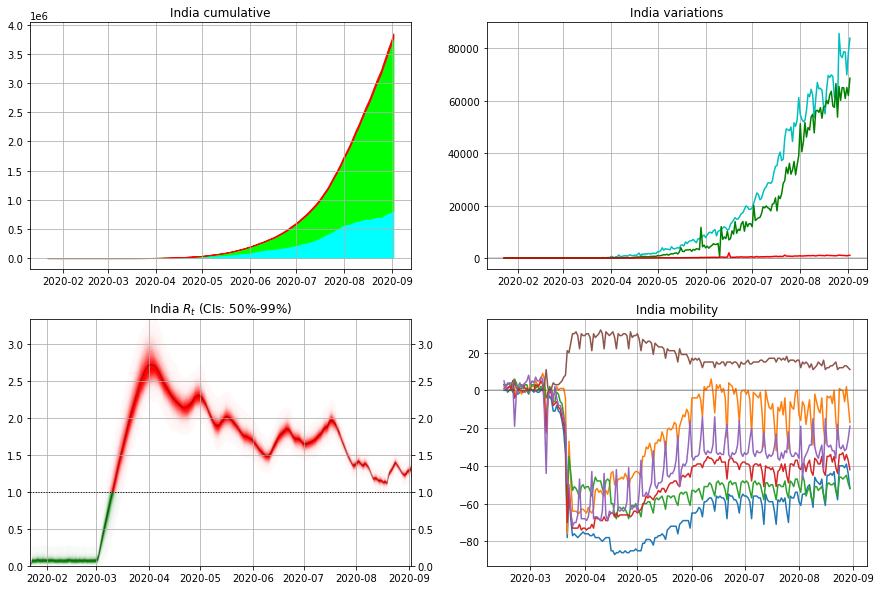

# Iran

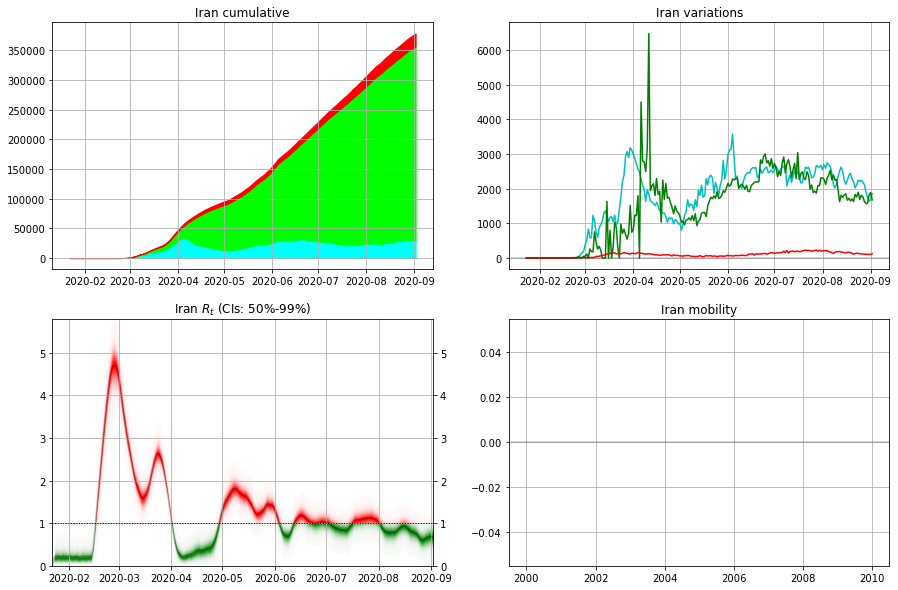

# Italy

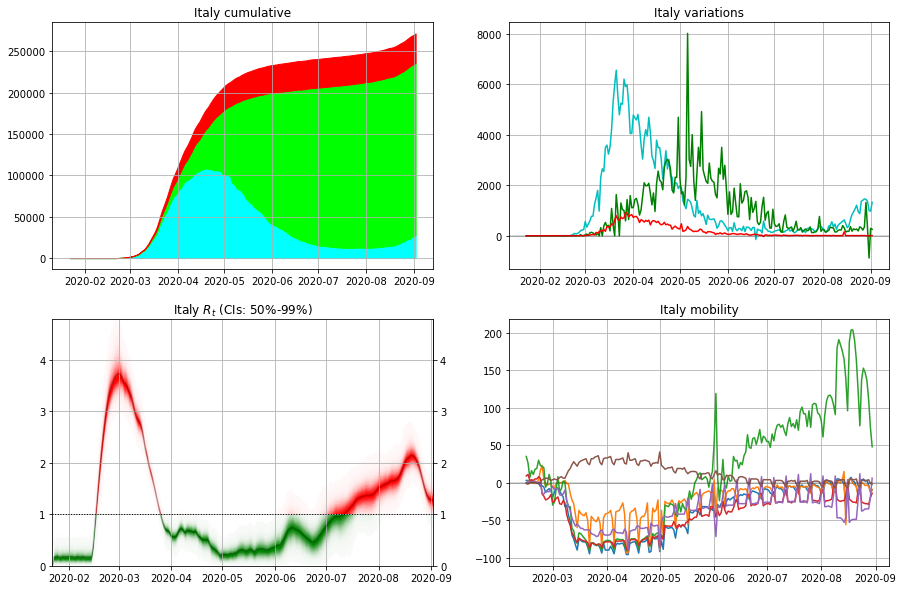

# Mexico

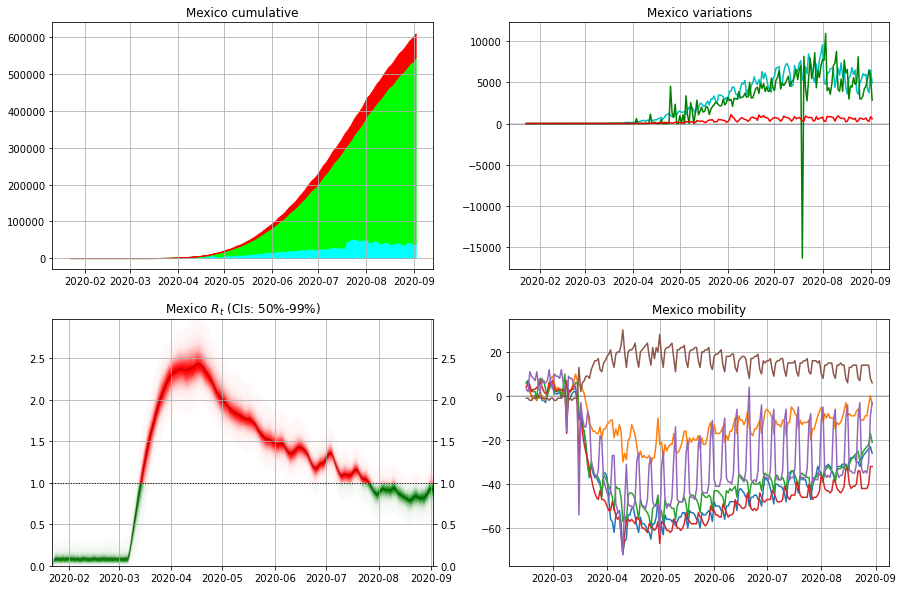

# Pakistan

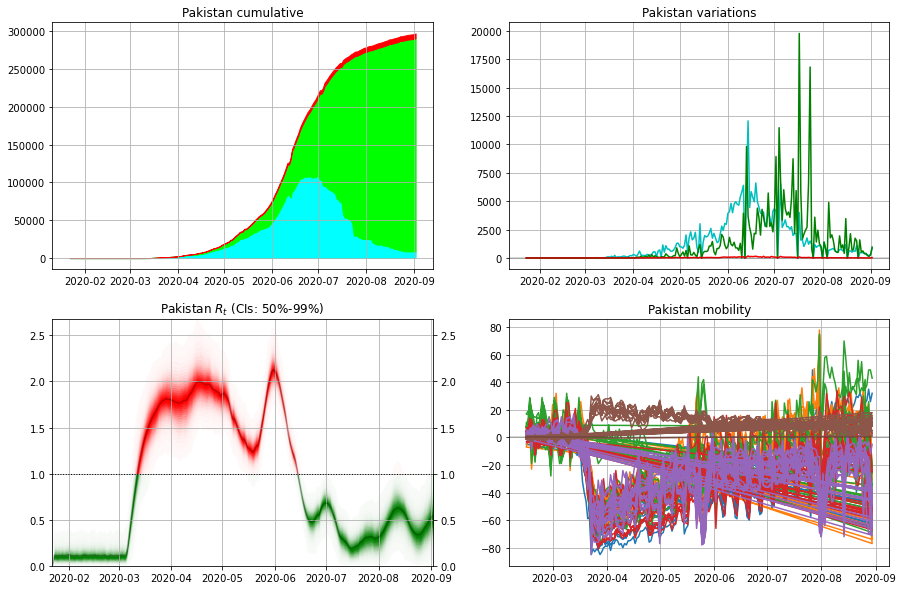

# Peru

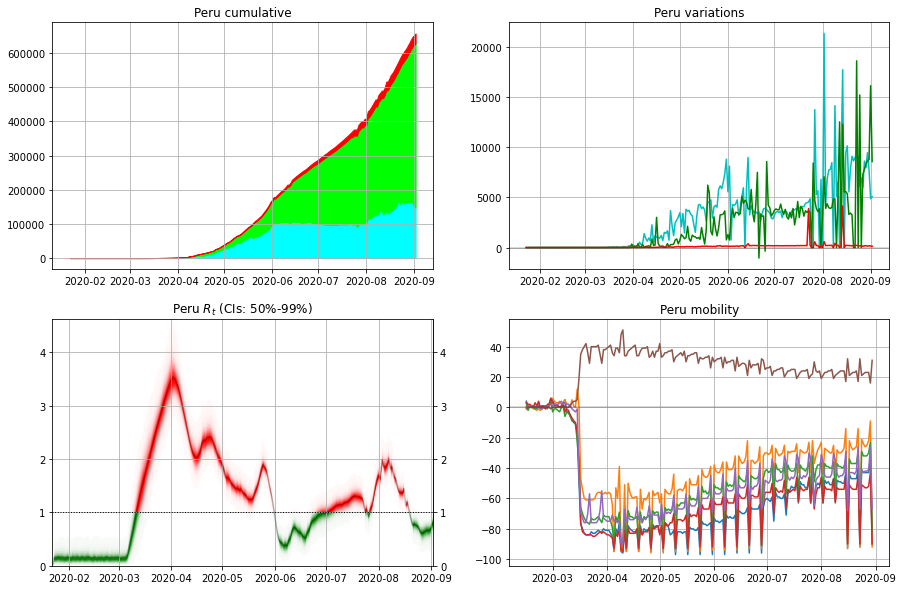

# Russia

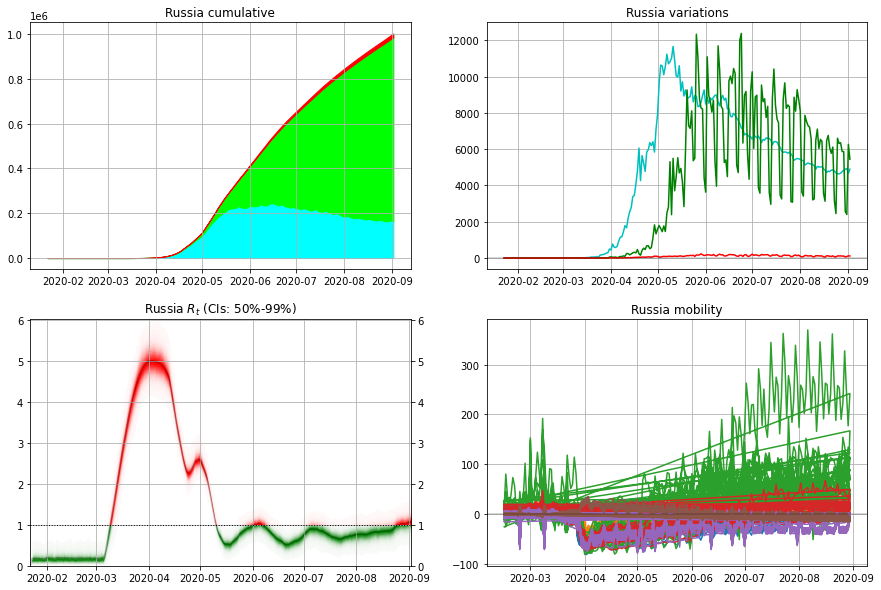

# Saudi Arabia

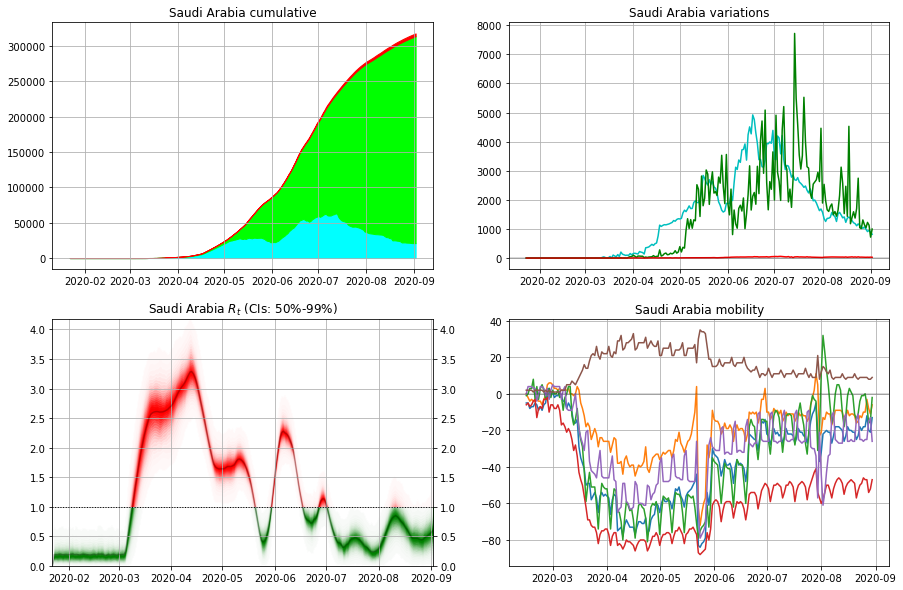

# South Africa

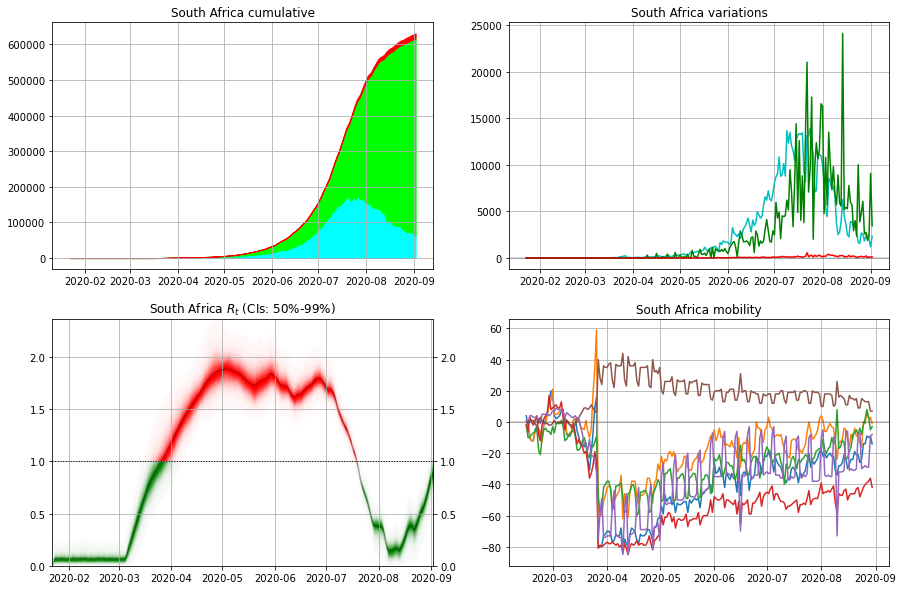

# Spain

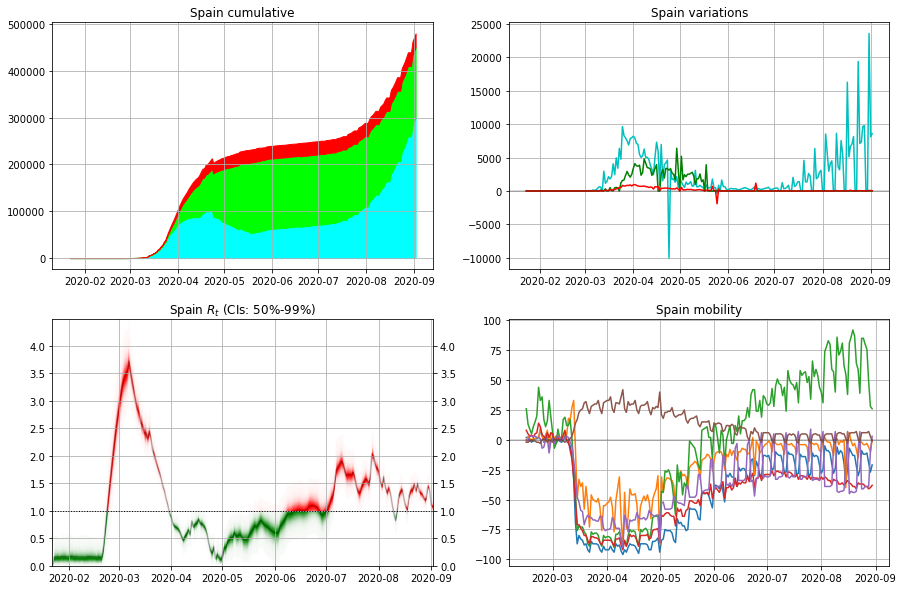

# Turkey

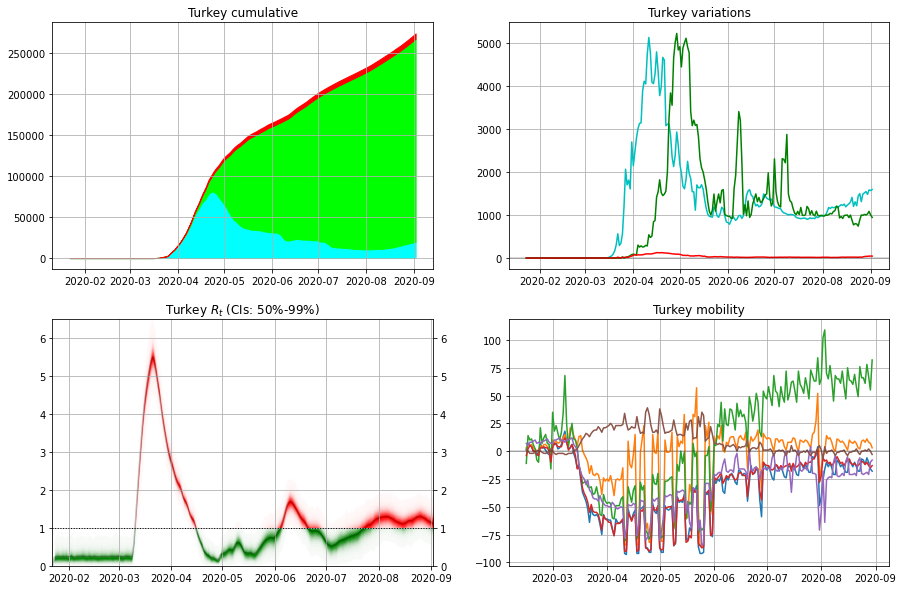

# US

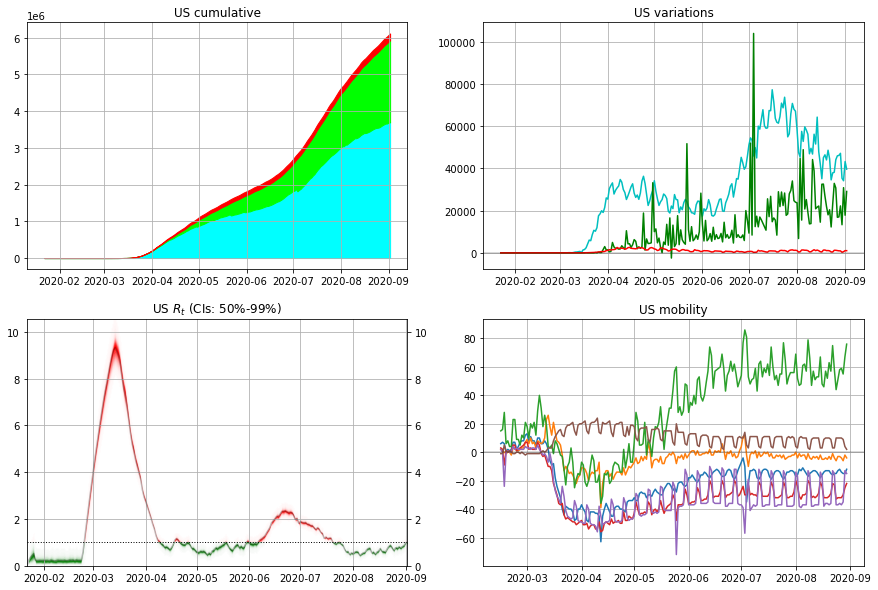

# United Kingdom

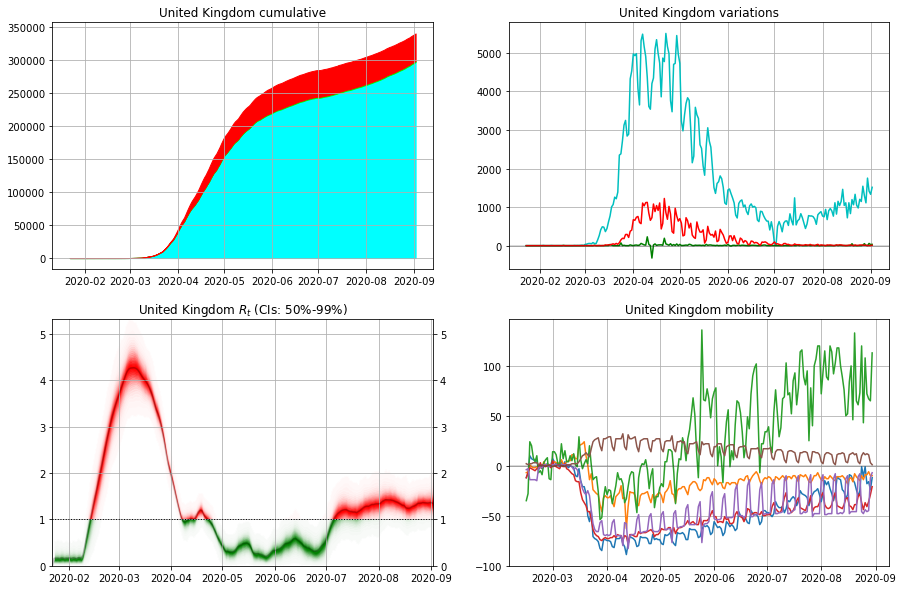

In [11]:
for country in best_countries:
    display(Markdown(f"# {country}"))
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    
    t = T.loc[country]
    if isinstance(t, pd.DataFrame):
        t = t.sum(axis=0)
    d = D.loc[country]
    if isinstance(d, pd.DataFrame):
        d = d.sum(axis=0)
    r = R.loc[country]
    if isinstance(r, pd.DataFrame):
        r = r.sum(axis=0)
    p = t - r - d
        
    ax[0,0].fill_between(days, 0, p, color='cyan')
    ax[0,0].fill_between(days, p, p+r, color='lime')
    ax[0,0].fill_between(days, p+r, p+r+d, color='red')
    ax[0,0].set_title(f"{country} cumulative")
    ax[0,0].grid()
    
    ax[0,1].plot(days, t.diff(), 'c')
    ax[0,1].plot(days, r.diff(), 'g')
    ax[0,1].plot(days, d.diff(), 'r')
    
    ax[0,1].axhline(0, c='k', alpha=.2)
    ax[0,1].set_title(f"{country} variations")
    ax[0,1].grid()
    
    g_country = country
    if country == "US":
        g_country = "United States"
        
    _df = google.loc[google["country_region"] == g_country]
    _df = _df.loc[_df.fillna("NONE")["sub_region_1"] == "NONE"]
    
    for column in _df.columns[4:]:
        ax[1,1].plot(
            _df.index, _df[column],
            label=column.replace("_", " ").title().split(" Percent")[0]
        )
    #ax[1,1].legend()
    ax[1,1].axhline(0, c='k', alpha=.2)
    ax[1,1].set_title(f"{country} mobility")
    ax[1,1].grid()
    
    filtered_t, t_ouliers = hampel_filter_pandas(t.diff(), 7, 2)

    smoothed = filtered_t.rolling(14,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=5).round()

    model_data = {
        "y": smoothed.values,
        "k": smoothed.values,
        "T": days.size,
    }
    
    jags_posteriors_italy = None

    jags_model = pyjags.Model(
        code=modelString, 
        data=model_data,
        chains=4, 
        adapt=adapt,
        progress_bar=False
    )

    jags_posteriors = jags_model.sample(
        warmup + sample, vars=["sigma_R", "R",]
    )

    percs = np.linspace(50, 99, 20)

    ymax = np.array([])
    uppers = np.ndarray(shape=(len(percs), days.size))
    lowers = np.ndarray(shape=(len(percs), days.size))

    pyjags_data = az.from_pyjags(jags_posteriors, warmup_iterations=warmup, save_warmup=False)
    summary = az.summary(pyjags_data, var_names="R", kind="stats")
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(pyjags_data.posterior.R, p, axis=1)
        upper = np.mean(upper, axis=0)
        lower = np.percentile(pyjags_data.posterior.R, 100-p, axis=1)
        lower = np.mean(lower, axis=0)
        ymax = np.append(ymax, upper.max())
        uppers[i] = upper
        lowers[i] = lower

    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers, lowers)):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax[1,0].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
        ax[1,0].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

    ax[1,0].plot(days, summary["mean"], c="k", alpha=.25)

    ax[1,0].axhline(1, c="k", ls=":", lw=1)

    ax[1,0].fill_between(days, 1, 12, color="red", zorder=0) #, alpha=.2)
    ax[1,0].fill_between(days, 0, 1, color="green", zorder=0) #, alpha=.2)

    ax[1,0].set_xlim(days[0], days[-1])

    ax[1,0].set_title(fr"{country} $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

    ax[1,0].set_ylim(0, ymax.max())
    ax[1,0].yaxis.set_ticks_position('both')
    ax[1,0].tick_params(labelright=True)
    ax[1,0].grid()
    
    fig.set_facecolor('w'); plt.show();
    plt.close(fig='all')